## Desafio - Módulo 4 - Machine Learning
##### **Com respotas do questionário**

## Objetivo:
* Análise exploratória dos dados (EDA - Exploratory Data Analysis).
* Preparação dos dados.
* Comparação e ajuste de modelos de classificação.


Você precisará trabalhar nas seguintes etapas:
- Explorar os dados.
- Pré-processar os dados.
- Construir o modelo.
- Montar as camadas.
- Compilar o modelo.
- Treinar o modelo.
- Avaliar a acurácia.
- Fazer predições.

Dataset: </br>
- 1. Retreinando um classificador de imagens
https://www.tensorflow.org/hub/tutorials/tf2_image_retraining?hl=pt
</br>
-2. Classifique flores com transferência de aprendizagem
https://www.tensorflow.org/hub/tutorials/image_feature_vector?hl=pt 


**The Flower Photos Database**<br>
Descrição

Assim como foi feito no trabalho prático, o objetivo desse exercício é classificar imagens pelo uso do Deep Learning (Keras e Tensorflow). Dessa vez, iremos utilizar dados de imagens de flores para ensinar à rede as novas classes que precisará reconhecer. Vamos usar um arquivo de fotos de flores licenciadas da creative-commons do Google. O conjunto de dados usado neste exemplo é distribuído como diretórios de imagens, com uma classe de imagem por diretório


## Tutorial 1 - Retreinando um classificador de imagens

In [1]:
# importando as bibliotecas

import warnings
warnings.filterwarnings("ignore")


import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.3.0
Hub version: 0.9.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [2]:
# Select the TF2 SavedModel module to use
module_selection = ("mobilenet_v2_100_224", 224) 
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [3]:
# Set up the Flowers dataset
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 4s 0us/step


In [4]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


In [5]:
# Defining the model
do_fine_tuning = False 

print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [6]:
# Training the model
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - 21s 231ms/step - loss: 0.9243 - accuracy: 0.7534 - val_loss: 0.7237 - val_accuracy: 0.8622
Epoch 2/5
91/91 [==============================] - 19s 213ms/step - loss: 0.6856 - accuracy: 0.8813 - val_loss: 0.7466 - val_accuracy: 0.8324
Epoch 3/5
91/91 [==============================] - 20s 218ms/step - loss: 0.6524 - accuracy: 0.8978 - val_loss: 0.6949 - val_accuracy: 0.8665
Epoch 4/5
91/91 [==============================] - 20s 219ms/step - loss: 0.6294 - accuracy: 0.9112 - val_loss: 0.6892 - val_accuracy: 0.8764
Epoch 5/5
91/91 [==============================] - 20s 220ms/step - loss: 0.6101 - accuracy: 0.9233 - val_loss: 0.7071 - val_accuracy: 0.8665


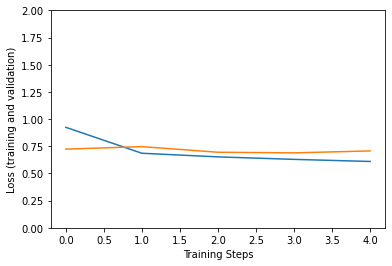

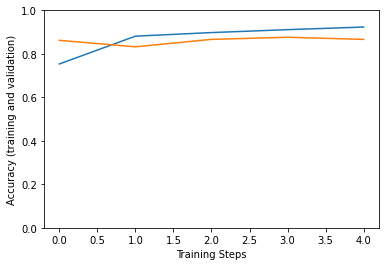

In [7]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [8]:
saved_model_path = "/tmp/saved_flowers_model"
tf.saved_model.save(model, saved_model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


INFO:tensorflow:Assets written to: /tmp/saved_flowers_model/assets


## Tutorial 2 - Classifique flores com transferência de aprendizagem


In [9]:
# Configuração 
import collections
import io
import math
import os
import random
from six.moves import urllib

from IPython.display import clear_output, Image, display, HTML

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [10]:
# O conjunto de dados de flores 
FLOWERS_DIR = './flower_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


def make_train_and_test_sets():
  """Split the data into train and test sets and get the label classes."""
  train_examples, test_examples = [], []
  shuffler = random.Random(RANDOM_SEED)
  is_root = True
  for (dirname, subdirs, filenames) in tf.gfile.Walk(FLOWERS_DIR):
    # The root directory gives us the classes
    if is_root:
      subdirs = sorted(subdirs)
      classes = collections.OrderedDict(enumerate(subdirs))
      label_to_class = dict([(x, i) for i, x in enumerate(subdirs)])
      is_root = False
    # The sub directories give us the image files for training.
    else:
      filenames.sort()
      shuffler.shuffle(filenames)
      full_filenames = [os.path.join(dirname, f) for f in filenames]
      label = dirname.split('/')[-1]
      label_class = label_to_class[label]
      # An example is the image file and it's label class.
      examples = list(zip(full_filenames, [label_class] * len(filenames)))
      num_train = int(len(filenames) * TRAIN_FRACTION)
      train_examples.extend(examples[:num_train])
      test_examples.extend(examples[num_train:])

  shuffler.shuffle(train_examples)
  shuffler.shuffle(test_examples)
  return train_examples, test_examples, classes

In [11]:
# Download the images and split the images into train and test sets.
download_images()
TRAIN_EXAMPLES, TEST_EXAMPLES, CLASSES = make_train_and_test_sets()
NUM_CLASSES = len(CLASSES)

print('\nThe dataset has %d label classes: %s' % (NUM_CLASSES, CLASSES.values()))
print('There are %d training images' % len(TRAIN_EXAMPLES))
print('there are %d test images' % len(TEST_EXAMPLES))

Flower photos are located in ./flower_photos

The dataset has 5 label classes: odict_values(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
There are 2934 training images
there are 736 test images


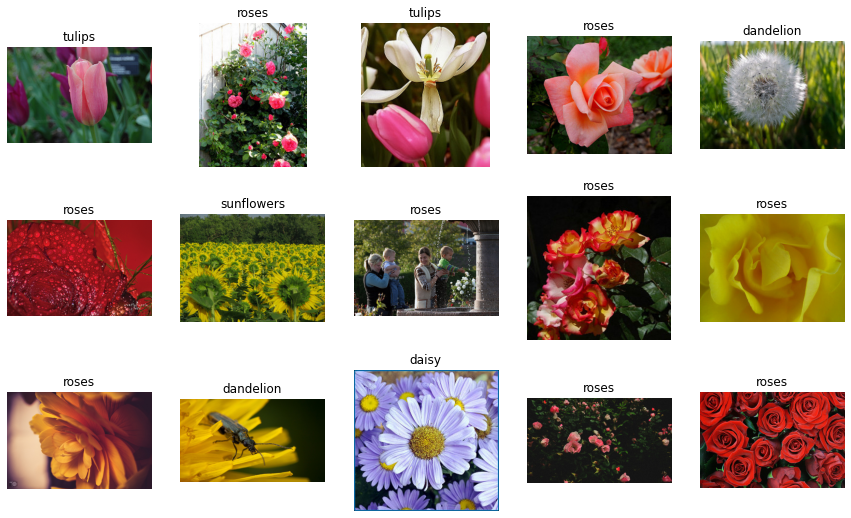

In [12]:
# Explore os dados

def get_label(example):
  """Get the label (number) for given example."""
  return example[1]

def get_class(example):
  """Get the class (string) of given example."""
  return CLASSES[get_label(example)]

def get_encoded_image(example):
  """Get the image data (encoded jpg) of given example."""
  image_path = example[0]
  return tf.gfile.GFile(image_path, 'rb').read()

def get_image(example):
  """Get image as np.array of pixels for given example."""
  return plt.imread(io.BytesIO(get_encoded_image(example)), format='jpg')

def display_images(images_and_classes, cols=5):
  """Display given images and their labels in a grid."""
  rows = int(math.ceil(len(images_and_classes) / cols))
  fig = plt.figure()
  fig.set_size_inches(cols * 3, rows * 3)
  for i, (image, flower_class) in enumerate(images_and_classes):
    plt.subplot(rows, cols, i + 1)
    plt.axis('off')
    plt.imshow(image)
    plt.title(flower_class)

NUM_IMAGES = 15 
display_images([(get_image(example), get_class(example))
               for example in TRAIN_EXAMPLES[:NUM_IMAGES]])

In [13]:
# Construir o modelo
LEARNING_RATE = 0.01

tf.reset_default_graph()

# Load a pre-trained TF-Hub module for extracting features from images. We've
# chosen this particular module for speed, but many other choices are available.
image_module = hub.Module('https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2')

# Preprocessing images into tensors with size expected by the image module.
encoded_images = tf.placeholder(tf.string, shape=[None])
image_size = hub.get_expected_image_size(image_module)


def decode_and_resize_image(encoded):
  decoded = tf.image.decode_jpeg(encoded, channels=3)
  decoded = tf.image.convert_image_dtype(decoded, tf.float32)
  return tf.image.resize_images(decoded, image_size)


batch_images = tf.map_fn(decode_and_resize_image, encoded_images, dtype=tf.float32)

# The image module can be applied as a function to extract feature vectors for a
# batch of images.
features = image_module(batch_images)


def create_model(features):
  """Build a model for classification from extracted features."""
  # Currently, the model is just a single linear layer. You can try to add
  # another layer, but be careful... two linear layers (when activation=None)
  # are equivalent to a single linear layer. You can create a nonlinear layer
  # like this:
  # layer = tf.layers.dense(inputs=..., units=..., activation=tf.nn.relu)
  layer = tf.layers.dense(inputs=features, units=NUM_CLASSES, activation=None)
  return layer


# For each class (kind of flower), the model outputs some real number as a score
# how much the input resembles this class. This vector of numbers is often
# called the "logits".
logits = create_model(features)
labels = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Mathematically, a good way to measure how much the predicted probabilities
# diverge from the truth is the "cross-entropy" between the two probability
# distributions. For numerical stability, this is best done directly from the
# logits, not the probabilities extracted from them.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
cross_entropy_mean = tf.reduce_mean(cross_entropy)

# Let's add an optimizer so we can train the network.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss=cross_entropy_mean)

# The "softmax" function transforms the logits vector into a vector of
# probabilities: non-negative numbers that sum up to one, and the i-th number
# says how likely the input comes from class i.
probabilities = tf.nn.softmax(logits)

# We choose the highest one as the predicted class.
prediction = tf.argmax(probabilities, 1)
correct_prediction = tf.equal(prediction, tf.argmax(labels, 1))

# The accuracy will allow us to eval on our test set. 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:
Use fn_output_signature instead


Instructions for updating:
Use fn_output_signature instead


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


In [14]:
# Treine a rede 
# How long will we train the network (number of batches).
NUM_TRAIN_STEPS = 100 
# How many training examples we use in each step.
TRAIN_BATCH_SIZE = 10 
# How often to evaluate the model performance.
EVAL_EVERY = 10 

def get_batch(batch_size=None, test=False):
  """Get a random batch of examples."""
  examples = TEST_EXAMPLES if test else TRAIN_EXAMPLES
  batch_examples = random.sample(examples, batch_size) if batch_size else examples
  return batch_examples

def get_images_and_labels(batch_examples):
  images = [get_encoded_image(e) for e in batch_examples]
  one_hot_labels = [get_label_one_hot(e) for e in batch_examples]
  return images, one_hot_labels

def get_label_one_hot(example):
  """Get the one hot encoding vector for the example."""
  one_hot_vector = np.zeros(NUM_CLASSES)
  np.put(one_hot_vector, get_label(example), 1)
  return one_hot_vector

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(NUM_TRAIN_STEPS):
    # Get a random batch of training examples.
    train_batch = get_batch(batch_size=TRAIN_BATCH_SIZE)
    batch_images, batch_labels = get_images_and_labels(train_batch)
    # Run the train_op to train the model.
    train_loss, _, train_accuracy = sess.run(
        [cross_entropy_mean, train_op, accuracy],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
    is_final_step = (i == (NUM_TRAIN_STEPS - 1))
    if i % EVAL_EVERY == 0 or is_final_step:
      # Get a batch of test examples.
      test_batch = get_batch(batch_size=None, test=True)
      batch_images, batch_labels = get_images_and_labels(test_batch)
      # Evaluate how well our model performs on the test set.
      test_loss, test_accuracy, test_prediction, correct_predicate = sess.run(
        [cross_entropy_mean, accuracy, prediction, correct_prediction],
        feed_dict={encoded_images: batch_images, labels: batch_labels})
      print('Test accuracy at step %s: %.2f%%' % (i, (test_accuracy * 100)))

Test accuracy at step 0: 25.82%
Test accuracy at step 10: 56.52%
Test accuracy at step 20: 65.76%
Test accuracy at step 30: 71.60%
Test accuracy at step 40: 69.43%
Test accuracy at step 50: 72.01%
Test accuracy at step 60: 76.36%
Test accuracy at step 70: 77.99%
Test accuracy at step 80: 77.04%
Test accuracy at step 90: 78.67%
Test accuracy at step 99: 76.90%


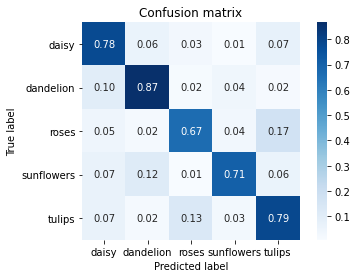

In [15]:
def show_confusion_matrix(test_labels, predictions):
  """Compute confusion matrix and normalize."""
  confusion = sk_metrics.confusion_matrix(
    np.argmax(test_labels, axis=1), predictions)
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = list(CLASSES.values())
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

show_confusion_matrix(batch_labels, test_prediction)

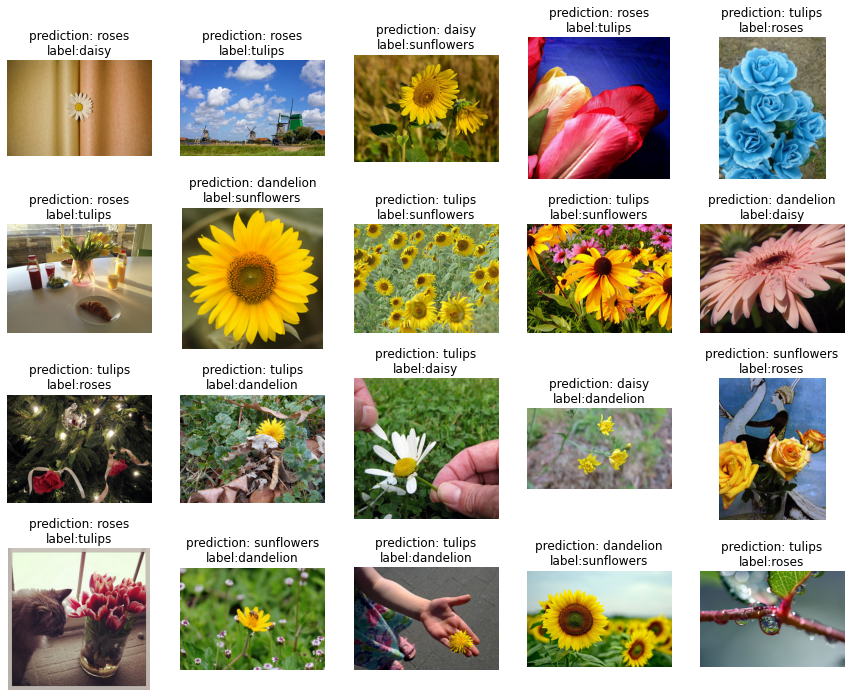

In [16]:
# Previsões incorretas
incorrect = [
    (example, CLASSES[prediction])
    for example, prediction, is_correct in zip(test_batch, test_prediction, correct_predicate)
    if not is_correct
]
display_images(
  [(get_image(example), "prediction: {0}\nlabel:{1}".format(incorrect_prediction, get_class(example)))
   for (example, incorrect_prediction) in incorrect[:20]])

## Questionário

#### Pergunta 1

Quando o aprendizado da rede neural ocorre?

- O aprendizado ocorre com novos conhecimentos de forma variável e constante sob as dinâmicas e demandas, seja de maneira direta ou indireta.

- O aprendizado ocorre quando a rede neural atinge uma solução generalizada para uma classe de problemas.

- O aprendizado acontece a partir da aquisição de conhecimentos, habilidades, valores e atitudes através do estudo, do ensino ou da experiência.

- O aprendizado ocorre quando se utiliza computadores como estratégia para promover interações e mediar a aprendizagem de acordo com as necessidades específicas.

#### Pergunta 2
Para grandes volumes de dados (modelos complexos), o desempenho de algoritmos baseados em aprendizado profundo é:

- Não há como fazer esse tipo de comparação.

- Igual às técnicas tradicionais em machine learning.

- Inferior às técnicas tradicionais em machine learning.

- Superior às técnicas tradicionais em machine learning.


#### Pergunta 3
Neste problema, quantas classes de flores foram identificadas?

- Quatro classes.

- Cinco classes.

- Duas classes.

- Três classes.


#### Pergunta 4
Uma rede neural que poderíamos utilizar no nosso desafio para reconhecer imagens é:

- Rede Neural Profunda.

- Rede Neural sem Camadas.

- Rede Neural de uma Camada.

- Rede Neural Oculta.


#### Pergunta 5
Pensando no conceito de Inteligência Artificial, podemos dizer que esse modelo é:

- Um modelo inteligente que recebe as características a serem validadas.

- Um modelo preciso e sem capacidade de generalizar.

- Um modelo inteligente que exibe as características as quais nós associamos à inteligência no comportamento humano.

- Um modelo que apenas repete instruções prévias.


#### Pergunta 6
Considere a afirmação “O desempenho do sistema deve melhorar na repetição da mesma tarefa e nas tarefas similares do domínio.”

Podemos dizer que ela se aplica ao nosso desafio?

- Podemos dizer que não fez parte do desafio.

- Podemos dizer que não se aplica ao desafio.

- Podemos dizer que se aplica parcialmente ao desafio.

- Podemos dizer que se aplica ao desafio.

#### Pergunta 7
Ao final, para fazer a separação das flores o modelo construído, utilizou-se da técnica de:

- Regressão linear.

- Separação binária.

- Classificação.

- Aprendizado por reforço.


#### Pergunta 8
Qual o tipo de técnica utilizada pelo modelo para classificar as imagens?

- Classificação Binária.

- Regressão Logística.

- Clusterização.

- Regressão Não Linear.


#### Pergunta 9
Podemos afirmar sobre a camada de convolução de uma rede neural CNN:

- É a mais importante operação de uma rede CNN.

- Atuam como alimentadores dos pesos.

- É uma única camada de saída em uma rede CNN.

- Detectam frases completas na rede.


#### Pergunta 10
Para que serve o comando plt.show()?

- Para apagar o conteúdo da tela.

- Para mostra o status do processamento.

- Para enviar dados para um device externo.

- Para plotar algo na tela.


#### Pergunta 11
Para que serve o comando model.fit?

- Ajustamento.

- Treinamento.

- Verificar a acurácia.

- Teste.


#### Pergunta 12
Em uma rede neural CNN, podemos afirmar sobre a camada de pooling que:

- Reduz drasticamente a dimensão espacial da entrada.

- Atua como pesos.

- Também é chamada de downpooling.

- Aumenta o overfitting.

#### Pergunta 13
Os dados baixados contendo as imagens estão separados em quantos diretórios?

- 4.

- 5.

- 3.

- 6.


#### Pergunta 14
O conjunto de dados utilizado tem quantas imagens?

- 3670.

- 3672.

- 2560.

- 4870.


#### Pergunta 15
Podemos considerar que o conjunto de dados utilizados para treinar o modelo foi:

- Equilibrado pelo peso.

- Não rotulado.

- Rotulado.

- Transformado à medida do uso.
